In [1]:
# General imports 
import os 
import re
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

import sys
import platform
from os.path import join as pjoin

sys.path.insert(0,'/code/src')
from bci.loaders import load
from bci.thresholds.thresholds import align_thresholds
from bci.trials.align import indep_roll
from bci.dataviz import traces
from bci.processing import processing

In [2]:
# set data path
platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
    
print('data directory set to', data_dir)

data directory set to /data/


In [3]:
# Load metadata csv file
metadata = pd.read_csv(os.path.join(data_dir, 'bci_task_metadata', 'bci_metadata.csv'))
# Get all mice available
subject_ids = np.sort(metadata['subject_id'].unique())
# Select one mice
n_subjects = len(subject_ids)
subject_id = 754303 #subject_ids[0]

In [4]:
this_mouse_metadata = metadata[metadata['subject_id']==subject_id].sort_values(by='session_number')
# Pick one session for this mouse
session_names = this_mouse_metadata.name.values
print('Selected subject is', subject_id)
#print('Selected session is', session_name)
i_session_name = session_names[2]
session = load.load_session_data(i_session_name)

Selected subject is 754303
BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-27_20-01-31_processed_2025-08-07_06-00-10

NWB file: single-plane-ophys_754303_2025-01-27_20-01-31_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-27_20-01-31_processed_2025-08-07_06-00-10/single-plane-ophys_754303_2025-01-27_20-01-31_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


All threshold files for mouse 754303: ['single-plane-ophys_754303_2025-01-27', 'single-plane-ophys_754303_2025-01-23', 'single-plane-ophys_754303_2025-01-29', 'single-plane-ophys_754303_2025-01-31', 'single-plane-ophys_754303_2025-02-03']

Found threshold file at: /data/bci-thresholds/single-plane-ophys_754303_2025-01-27
total difference in dataframes: 5


In [5]:
session.keys()

dict_keys(['nwb_file', 'epoch_table', 'dff_traces', 'roi_table', 'frame_rate', 'bci_trials', 'thresholds'])

In [6]:
pre_post = []
pre_post_o_rois = []
for stimulus_name in photostim.stimulus_name.unique():

    nwb_file = session['nwb_file']
    epoch_table = session['epoch_table']
    dff_traces=session['dff_traces']
    photostim = nwb_file.stimulus["PhotostimTrials"].to_dataframe()
    frame_rate = session['frame_rate']
    roi_table = session['roi_table']

    # Remove ROIs with traces that are NaNs (note - this takes a few seconds)
    valid_trace_ids = [i for i in range(dff_traces.shape[1]) if np.isnan(dff_traces[0, i])==False]
    # Limit ROI table to non-NaN traces
    roi_table2 = roi_table.loc[valid_trace_ids]

    # Find the likely somatic ROIs
    soma_probability = 0.005 # Emperically determined threshold - just trust us
    # Limit to valid somatic ROIs
    valid_rois = roi_table2[roi_table2.soma_probability>soma_probability]
    pho1_trials = photostim[photostim['stimulus_name']==stimulus_name]
    # Remove first and last trial
    pho1_trials=pho1_trials.drop(index=[pho1_trials.index[0],pho1_trials.index[-1]]) 
    pho1_trials.reset_index(inplace=True)
    stim_duration = np.ceil(pho1_trials['duration'].unique()*frame_rate)

    # times
    photostim_epoch1 = epoch_table[epoch_table.stimulus_name==stimulus_name]
    start_phos1_epoch = photostim_epoch1.loc[photostim_epoch1.index[0]].start_frame
    stop_phos1_epoch = photostim_epoch1.loc[photostim_epoch1.index[0]].stop_frame
    start_phos1_trial = pho1_trials['start_frame']-start_phos1_epoch 
    stop_phos1_trial = pho1_trials['stop_frame']-start_phos1_epoch
    duration_phos1 = np.round(pho1_trials['duration']*frame_rate).astype(int)

    # Select relevant epoch
    dff_phos1 = dff_traces[start_phos1_epoch:stop_phos1_epoch, :]
    dff_phos1 = dff_phos1.T# Transpose so rows are ROI IDs

    stim_roi_idx = pho1_trials['closest_roi'].unique()
    for i_stim in stim_roi_idx:
        if i_stim in valid_rois.index:
            valid_rois = valid_rois.drop(i_stim,inplace=False)
            valid_rois = valid_rois.sort_index()

    dff_phos1_valid = dff_phos1[valid_rois.index.values, :]

    roi_original_idx = valid_rois.reset_index()['id']
    pre_post_o_rois.append(roi_original_idx)
    #cn_new_idx = roi_original_idx[roi_original_idx==target_roi_idx].index[0]
    # Smooth dff
    smoothing_window = 10
    smooth_dff_valid = np.full(dff_phos1_valid.shape,np.nan)
    kernel = np.ones(smoothing_window) / smoothing_window
    for itr,trial in enumerate (dff_phos1_valid):
        smooth_dff_valid[itr] = np.convolve(trial, kernel, mode='same')

    # Organize data by trials
    n_rois = smooth_dff_valid.shape[0]
    n_trials = len(start_phos1_trial)
    time_before=30
    #np.min(stop_phos1_trial-start_phos1_trial)
    max_tr_duration = int(time_before + stim_duration + 70)
    dff_by_trial = np.full((n_rois,n_trials,max_tr_duration),np.nan)
    for itr,(ist,istp) in enumerate(zip(start_phos1_trial,stop_phos1_trial)):
        ist = ist -time_before
        dff_by_trial[:,itr,:] = smooth_dff_valid[:,ist:ist+max_tr_duration]

    # it = 100
    # stim_roi = 0#roi_original_idx[roi_original_idx==pho1_trials['closest_roi'][it]].index[0]                        
    # plt.plot(dff_by_trial[stim_roi,it])
    # plt.vlines(time_before,0,np.max(dff_by_trial[stim_roi,it]),'k')

    grouped = pho1_trials.groupby(['closest_roi'])
    stim_roi_trials = {}
    for name, group in grouped:
        trials_idx = group.index
        stim_roi_trials[name[0]] = dff_by_trial[:,trials_idx]


    all_conditions_trials = []
    for key in stim_roi_trials.keys():
        all_conditions_trials.append(np.mean(stim_roi_trials[key],axis=1))
    all_conditions_trials = np.array(all_conditions_trials)
    n_conditions = all_conditions_trials.shape[0]
    n_frames = all_conditions_trials.shape[2]

    x = np.transpose(all_conditions_trials,(1,0,2)).reshape(n_rois,-1).T

    pre_post.append(x)

NameError: name 'photostim' is not defined

In [ ]:
# invalid_roi = []
# for i_stim in stim_roi_idx:

#     if not(i_stim in valid_rois.index):
#         try:
#             valid_rois = pd.concat((valid_rois, roi_table2.loc[[int(i_stim)], :]), axis=0)
#             valid_rois = valid_rois.sort_index()
#         except:
#             invalid_roi.append(int(i_stim))

# key = list(stim_roi_trials.keys())[1]
# new_stim_roi_idx = 10#roi_original_idx[roi_original_idx==key].index[0]
# fig,ax = plt.subplots(figsize=(10,5))
# y = stim_roi_trials[key][new_stim_roi_idx]
# y_mean = np.mean(y,axis=0)
# y_std = np.std(y,axis=0)
# ax.fill_between(range(len(y_mean)),y_mean - y_std, y_mean + y_std, color='lightblue', alpha=0.5, label='Standard Deviation')
# ax.plot(y_mean)

In [ ]:
plt.close('all')

In [ ]:
#_=plt.plot(np.array(all_conditions_trials)[0,:30].T)

In [ ]:
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler

In [ ]:
pca = PCA(n_components=0.90)

In [ ]:
print(np.sum(pre_post_o_rois[0]!=pre_post_o_rois[1]))

0


In [ ]:
#X_scaled = StandardScaler().fit_transform(x)
x1 = pre_post[0]
x2 = pre_post[1]
pca.fit(x1)

,n_components,0.9
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [ ]:
print(pca.explained_variance_ratio_)
print(len(pca.explained_variance_ratio_))

[0.58072983 0.18811489 0.0321579  0.01789742 0.00991128 0.00960507
 0.00767595 0.00697247 0.00613958 0.00526885 0.00473333 0.00464181
 0.0041947  0.00380588 0.00357726 0.00346058 0.0033077  0.00307813
 0.00300977 0.00286736]
20


In [ ]:
x1_trans = pca.transform(x1)
x2_trans = pca.transform(x2)

In [ ]:
by_cond1 = x1_trans.T.reshape(len(pca.explained_variance_ratio_),n_conditions,n_frames)
by_cond2 = x2_trans.T.reshape(len(pca.explained_variance_ratio_),n_conditions,n_frames)

In [ ]:
n_conditions

50

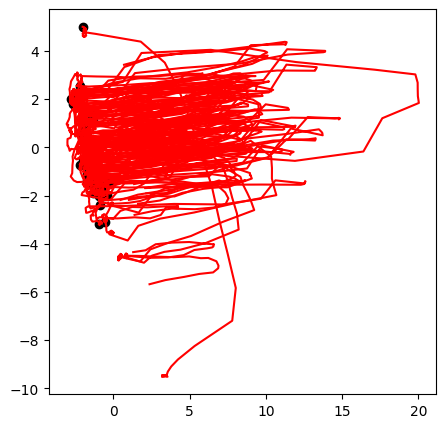

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
for i in range(by_cond1.shape[1]):

    ax.plot(by_cond1[0,i],by_cond1[1,i],c='r' )
    ax.scatter([by_cond1[0,i,0]],[by_cond1[1,i,0]],c='k')

/tmp/ipykernel_174443/2544424989.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(5,5))


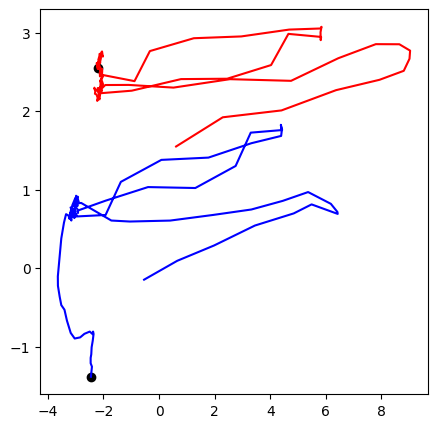

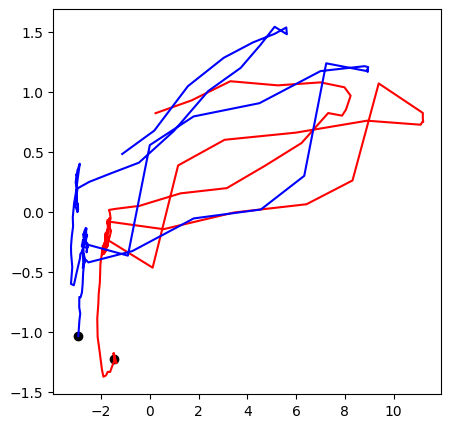

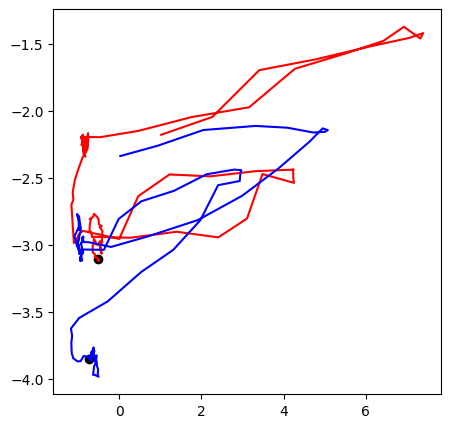

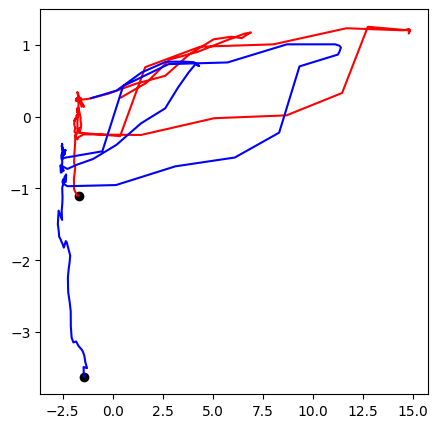

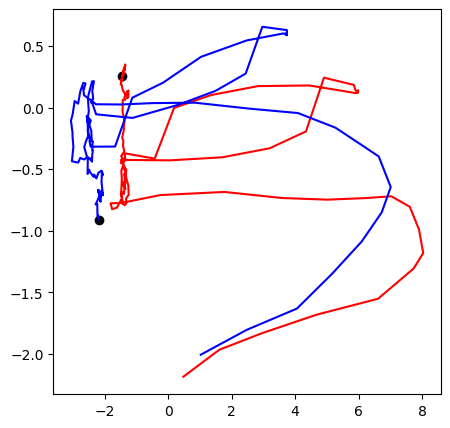

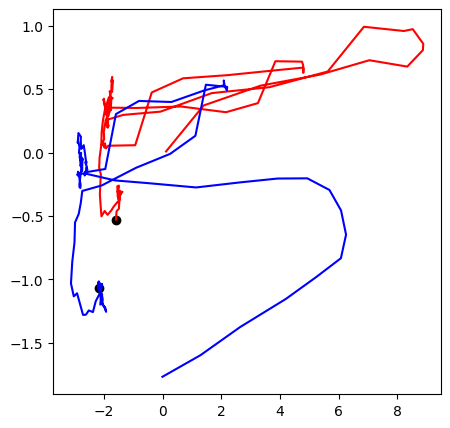

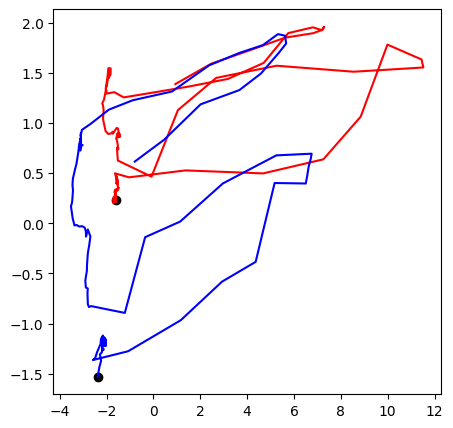

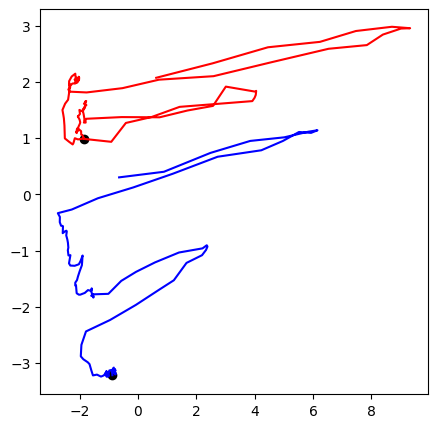

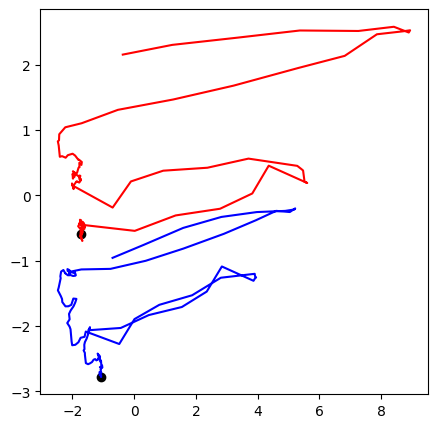

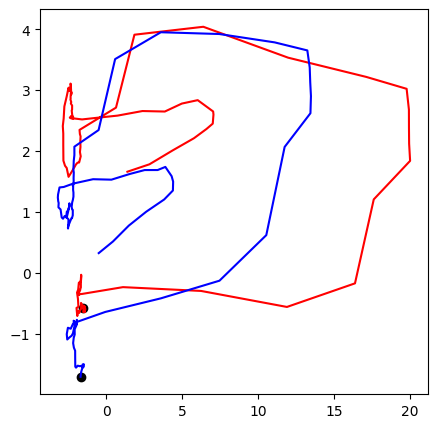

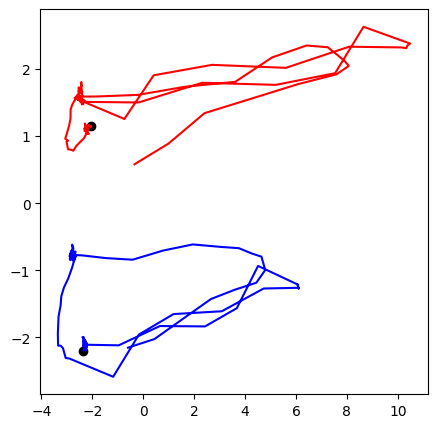

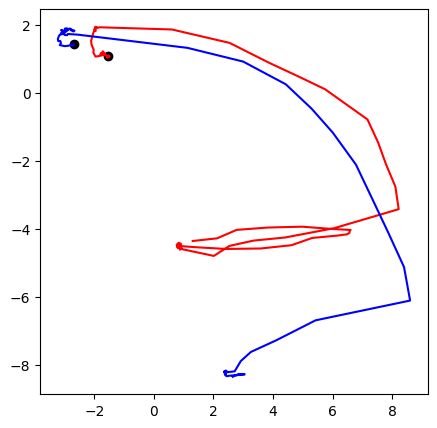

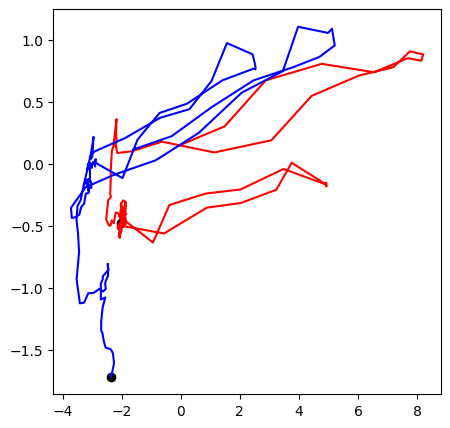

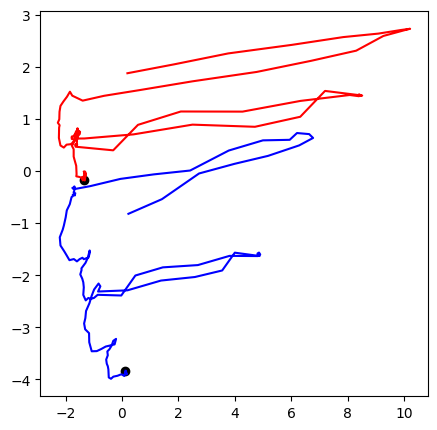

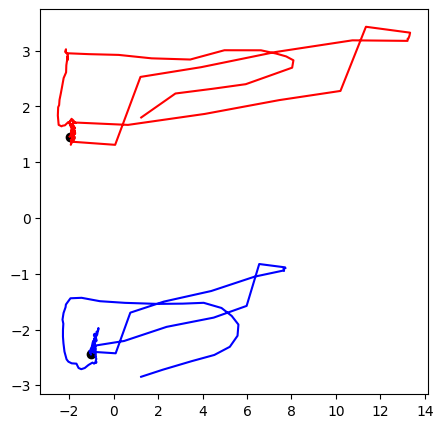

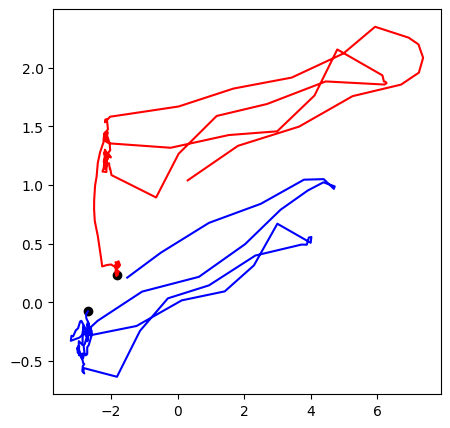

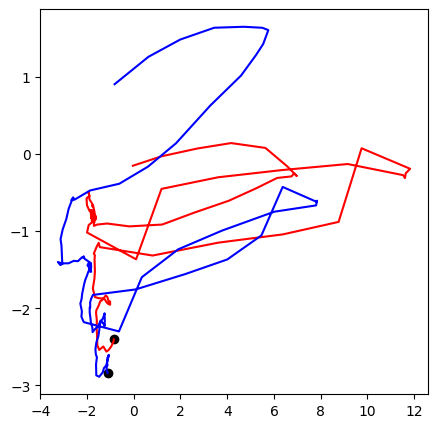

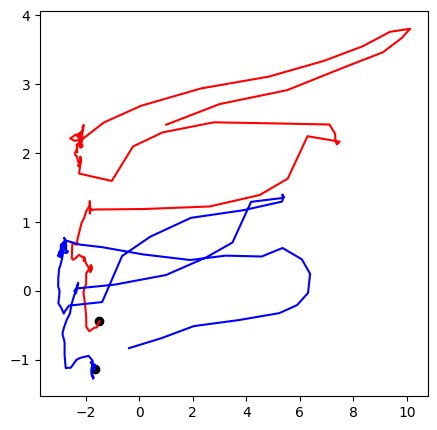

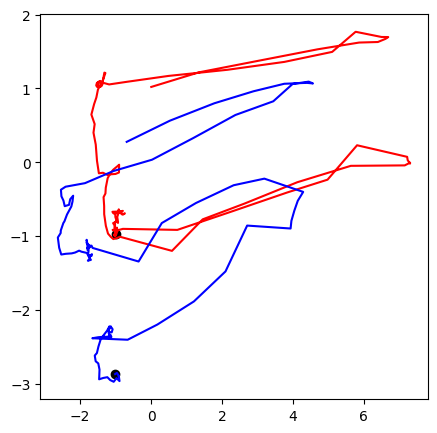

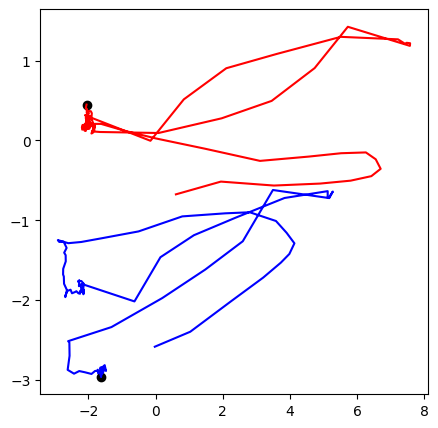

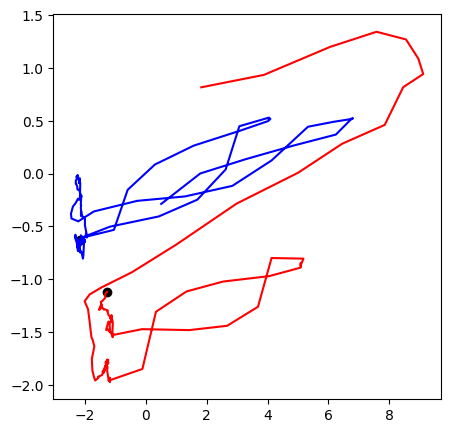

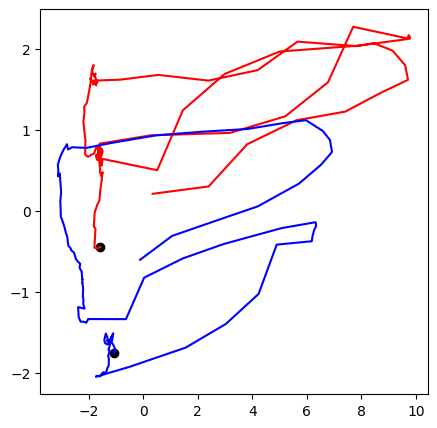

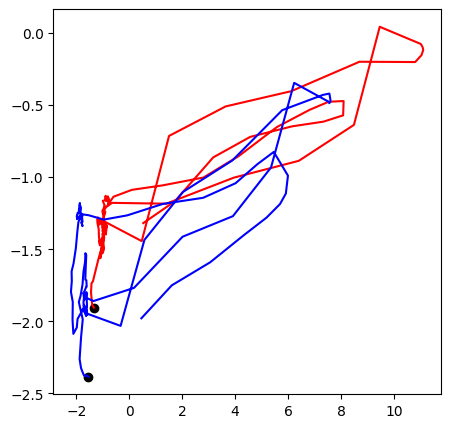

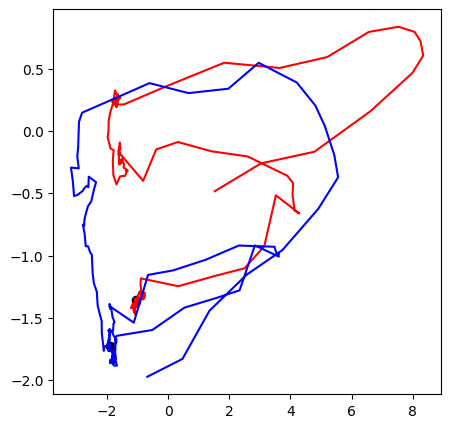

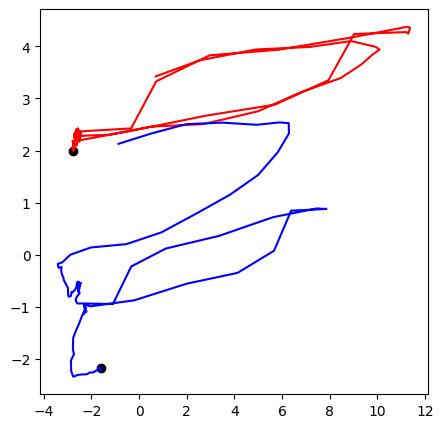

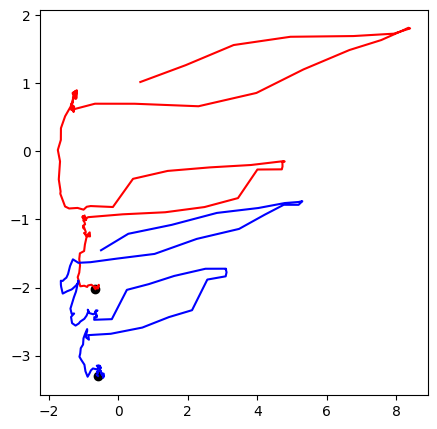

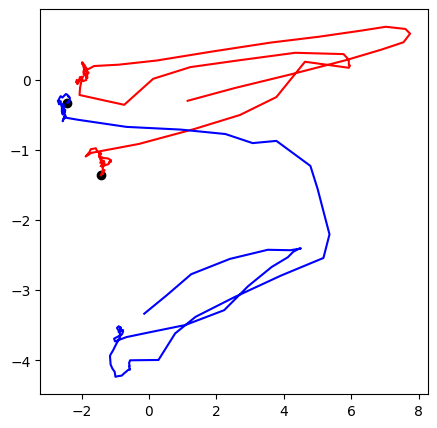

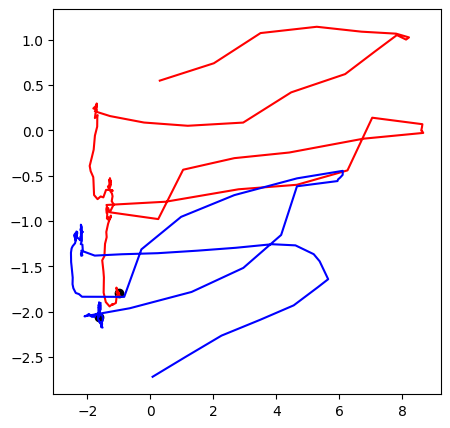

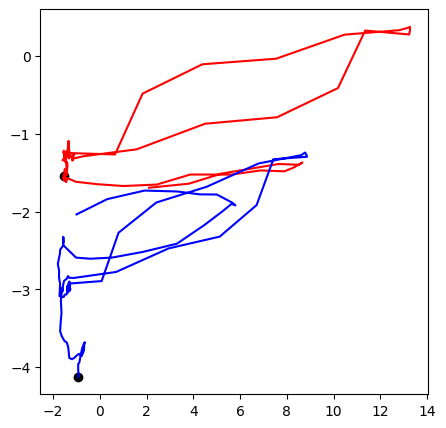

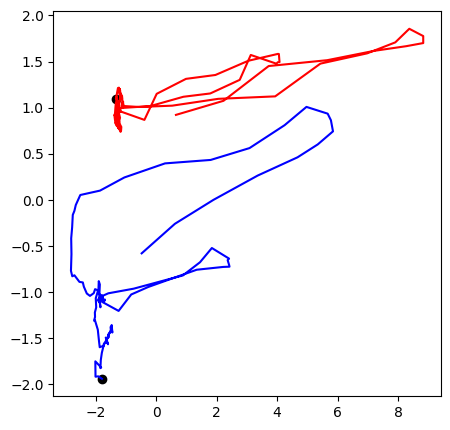

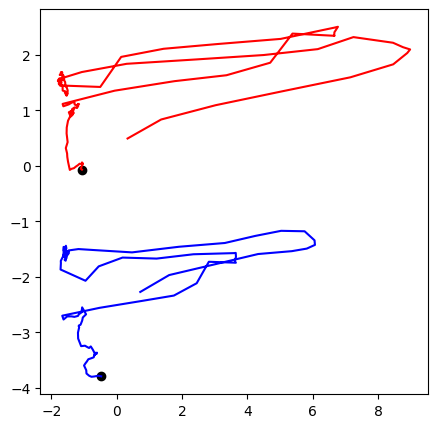

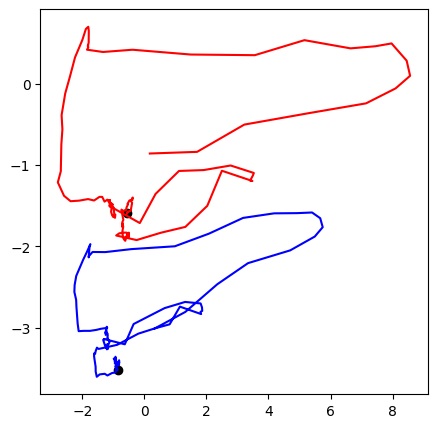

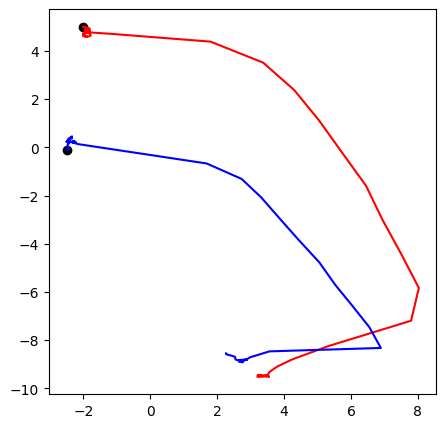

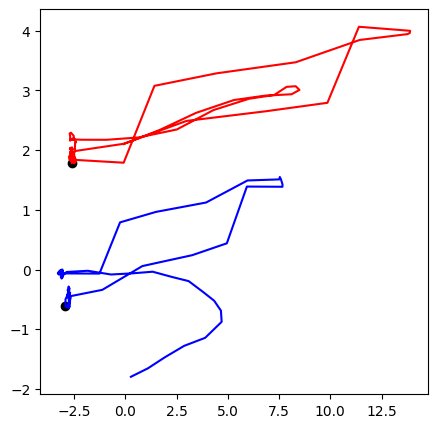

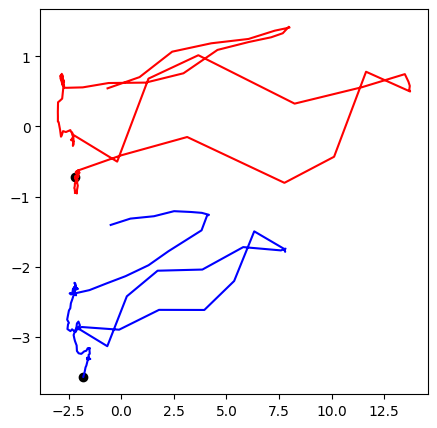

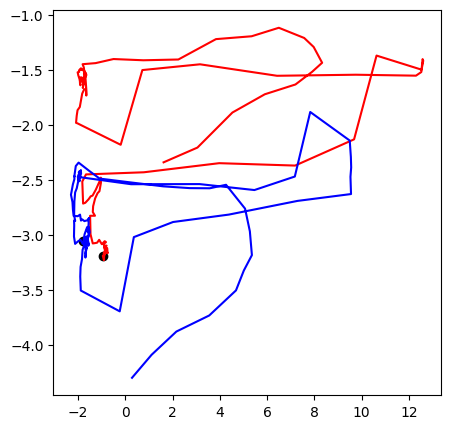

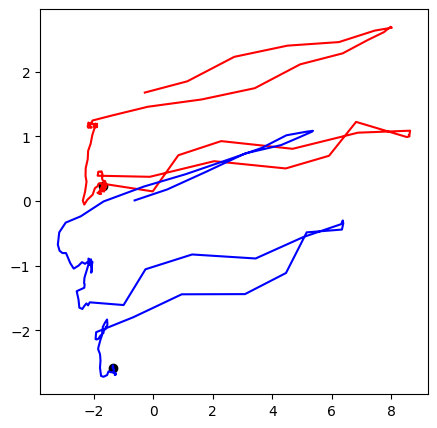

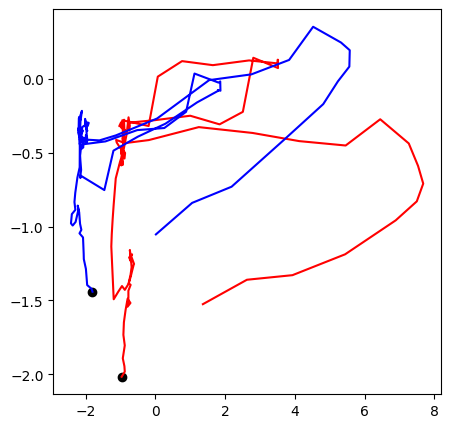

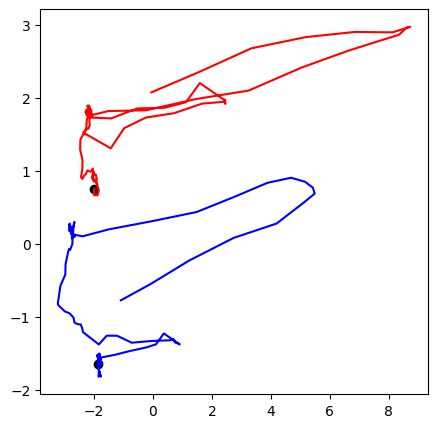

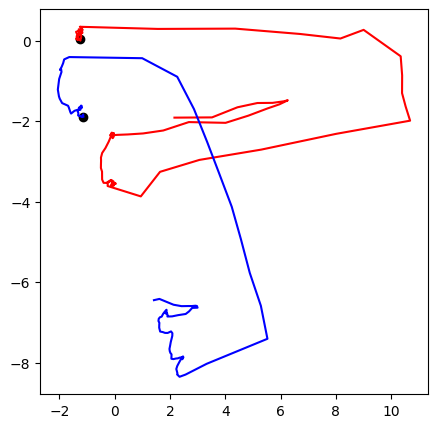

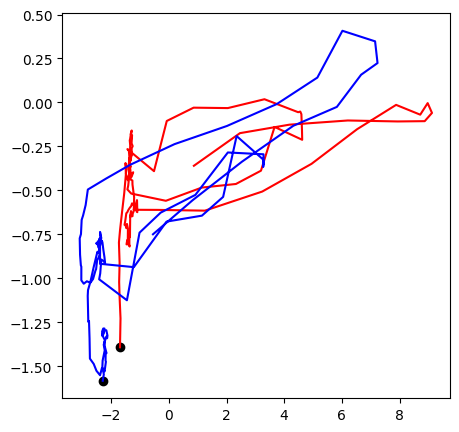

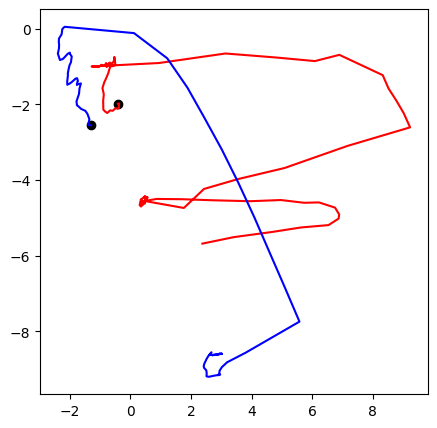

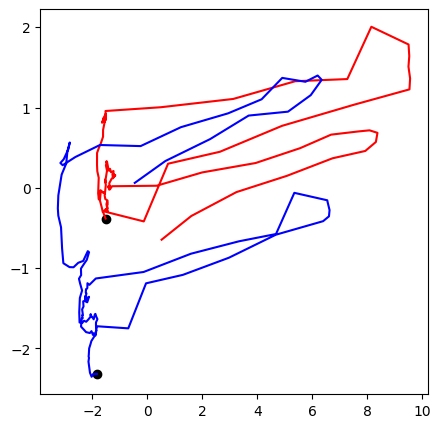

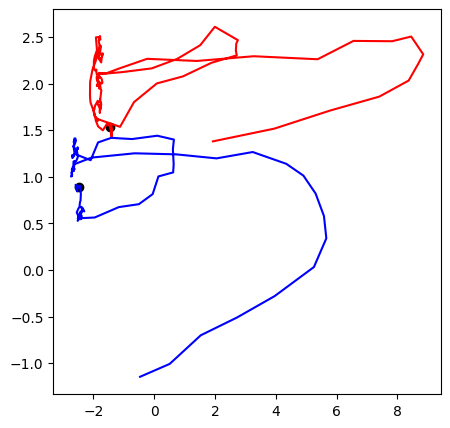

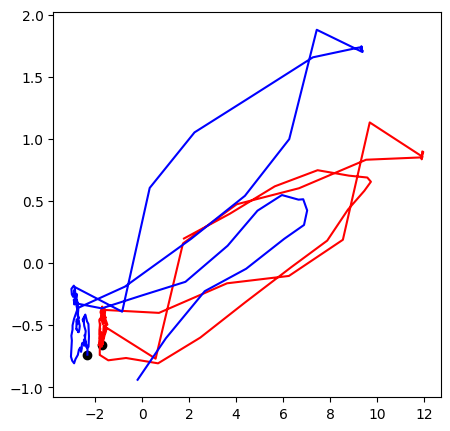

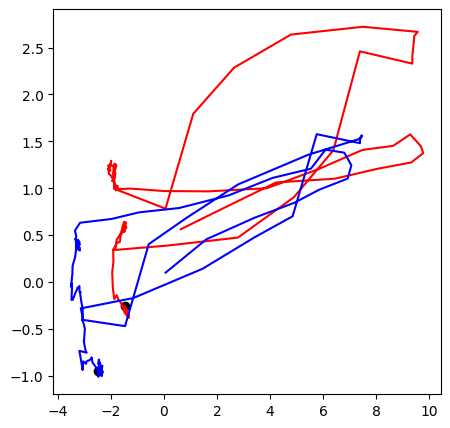

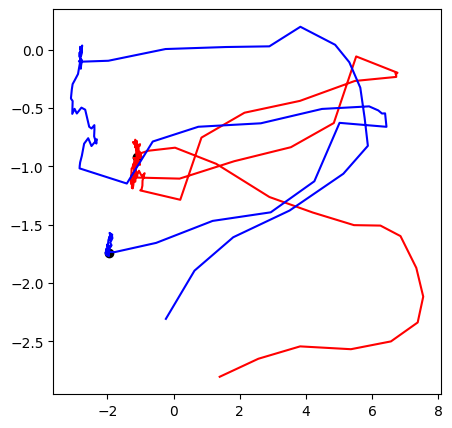

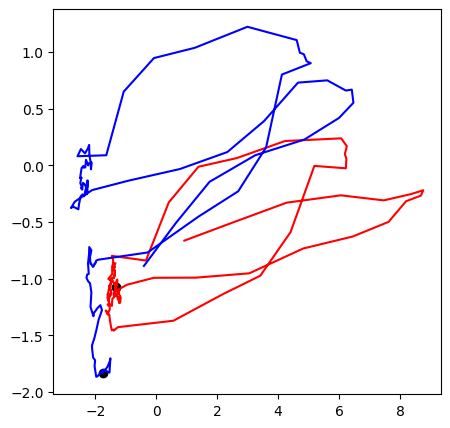

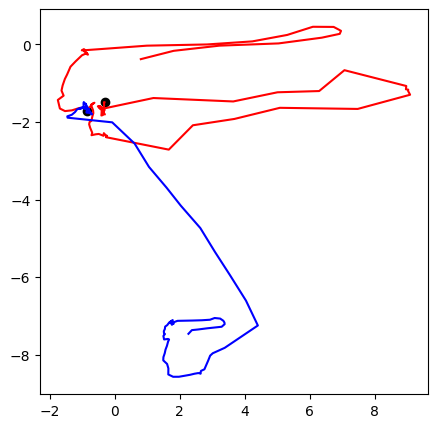

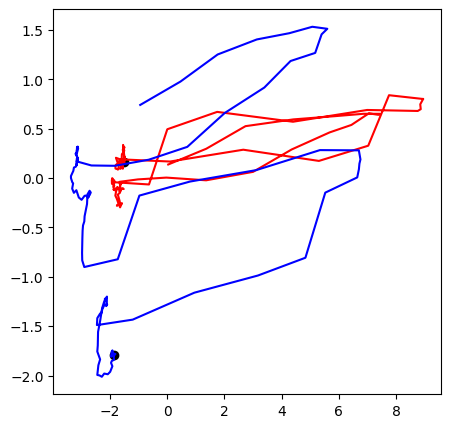

In [ ]:
cols= 4
rows = int(np.ceil(n_conditions/cols))
#fig,ax = plt.subplots(rows,cols,figsize=(10*rows,5*cols))

for i in range(by_cond1.shape[1])[:5]:
    fig,ax = plt.subplots(figsize=(5,5))

    ax.plot(by_cond1[0,i],by_cond1[1,i],c='r' )
    ax.scatter([by_cond1[0,i,0]],[by_cond1[1,i,0]],c='k')

    ax.plot(by_cond2[0,i],by_cond2[1,i],c='b' )
    ax.scatter([by_cond2[0,i,0]],[by_cond2[1,i,0]],c='k')


np.int64(0)